# SVGA

# Pseudo Code

1. Find the nearest polygon that intersect with direct path.
  - find whether the path crosses each polygon
  - if it crosses polygons find distance between path
  - find the index of polygon with lowest distance

2. Find the two outermost points on the polygon, from the perspective of the line.
  - find the visibile points of the polygon from point
    - take start as a point and each vertex of the polygon as a line segment
    - check if intersection of polygon and the line segment is a point, if yes, it is a visible point
  - find points that have max dist from the intersecting line segment on both sides.

3. Form a path taking the start point as start point, and the nearest outermost point (see code for logic, its a little complex) as end point, repeat the steps 1 and 2 recursively, taking path = (previous end point, next nearest outermost point) until there is no polygon between start and end points.

4. Do this until there is no polygon between the n-1 th and the end point of the path.

In [246]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from shapely.geometry import Point, LineString, MultiPoint, LinearRing
from shapely.geometry.polygon import Polygon

visited_points={}

def make_path(start, end):
  path = LineString([start, end])
  return path

def nearest_polygon(start,end,polys):
  """
  Finds the index of the nearest polygon to the start points
  inputs: start point (start), polygon array (polys)
  output: index of nearest polygon in the array
  """
  nearest_dist = float('inf')
  nearest_idx = 0
  path = make_path(start,end)

  for idx, poly in enumerate(polys):
    if path.crosses(poly) and start.distance(poly)<nearest_dist:
      nearest_dist = start.distance(poly)
      nearest_idx = idx
  return nearest_idx

def visible_points(start, poly):
  """
  Finds the vertices of a polygon that are visible from the start point
  inputs: start point (start), polygon
  """
  vis_points = []
  for coord in list(poly.exterior.coords[:-1]):
    line = LineString([start, Point(coord[0],coord[1])])

    # vertex is visible if the line it forms with start point intersects the polygon at a point,
    # not a line or any other shape
    if line.intersection(poly).geom_type == 'Point':
      vis_points.append(coord)
  return vis_points

def adjacent_points(poly, vertex):
  """
  input: polygon, a vertex of the polygon
  output: adjacent points of a vertex in a polygon
  """
  coords = list(poly.exterior.coords)[:-1]
  idx = coords.index(vertex)
  return [coords[idx-1],coords[(idx+1)%len(coords)]]

def outermost_points(polys, path):
  """
  Finds the outermost points of the nearest polygon that falls in line of sight of path
  inputs: polygon array (polys), path
  output: two outermost points on nearest polygon
  """
  start = Point(path.bounds[0], path.bounds[1])
  end = Point(path.bounds[-2], path.bounds[-1])

  nearest_idx = nearest_polygon(start,end,polys)
  
  #find visible vertices of the nearest polygon
  vis_points = visible_points(start, polys[nearest_idx])
  
  if len(vis_points)<2:
    return adjacent_points(polys[nearest_idx],(start.x,start.y))
    
  #find vertices on each side of the line
  sides=[[],[]]
  for point in vis_points:
    if LinearRing([start.coords[0], end.coords[0], point]).is_ccw:
      sides[0].append(point)
    else:
      sides[1].append(point)
  
  #find extreme points on each side
  outermost_points=[]
  for side in sides:
    farthest_dist_side = 0
    farthest_idx_side = 0
    if len(side)!=0:
      for idx, point in enumerate(side):
        if Point(point).distance(path)>farthest_dist_side:
          farthest_dist_side = Point(point).distance(path)
          farthest_idx_side = idx
      outermost_points.append(side[farthest_idx_side])
    else:
      outermost_points.append((None, None)) #i.e. whole side is invisible

  #find extreme points on each side
  return outermost_points

def find_paths(start, end, polys):
  """
  inputs: start point, end point, map - polygons
  output: a list of paths
  """
  tempo_polys = sorted(polys,key=lambda x: x.distance(start), reverse=False)[:] # sorted list of polygons by distance from start point
  temp_start = start

  planned_path = []

  i=0
  while True:
    temp_polys = tempo_polys # discard previous polygon
    temp_path = make_path(temp_start,end)

    #checks if any polygon crosses path, if not, loop can break as there is a direct path to the end
    crosses = False
    for poly in temp_polys:
      crosses = True if temp_path.crosses(poly) == True else crosses
  
    # for visualization/debug purposes
    for poly in polys:
      plt.plot(*poly.exterior.xy, 'g')
    plt.plot(*temp_path.xy, 'rx-')
    plt.show()

    i+=1
    if crosses:
      outermost_pts = outermost_points(temp_polys,temp_path)

      #for visualization/debug purposes
      plt.scatter([x[0] for x in outermost_pts], [x[1] for x in outermost_pts])
      
      # to prevent oscillation between same locally optimal points, keep track of visited points
      if str(Point(outermost_pts[0])) in visited_points: 
        temp_end = Point(outermost_pts[1])
      elif str(Point(outermost_pts[1])) in visited_points:
        temp_end = Point(outermost_pts[0])
      else:
        flag = end.distance(Point(outermost_pts[0])) < end.distance(Point(outermost_pts[1]))
        temp_end = Point(outermost_pts[0]) if flag else Point(outermost_pts[1])

      new_paths = find_paths(temp_start,temp_end,temp_polys)
      for path in new_paths:
        planned_path.append(path)
      
      visited_points[str(temp_start)] = True
      temp_start = temp_end
    else:
      new_path = make_path(temp_start,end)
      planned_path.append(new_path)

      return planned_path

## Setting up the polygons (that represent geo fences) and the start & end points

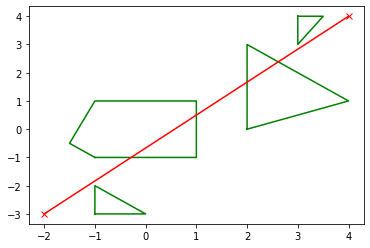

In [247]:
polys = np.array([Polygon([[-1,-1],[-1.5,-0.5], [-1,1], [1,1], [1,-1]]),
                  Polygon([[-1,-3], [-1,-2], [0,-3]]),
                  Polygon([[2,0], [2,3], [4,1]]),
                  Polygon([[3,4], [3,3], [3.5,4]]),])

start = Point(-2,-3)
end = Point(4,4)

for poly in polys:
  plt.plot(*poly.exterior.xy, 'g')

path = make_path(start, end)
plt.plot(*path.xy, 'rx-')

plt.show()

# The full final path

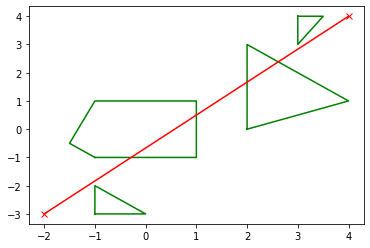

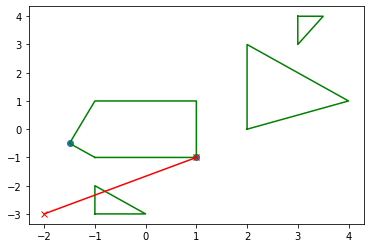

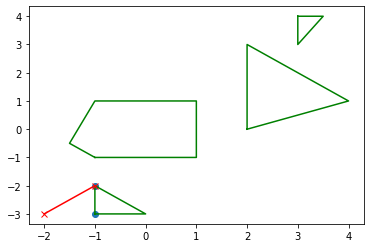

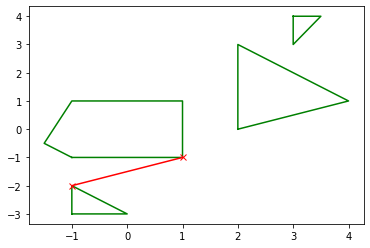

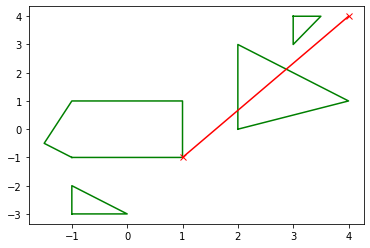

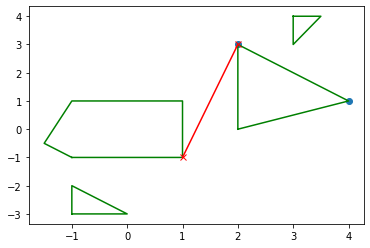

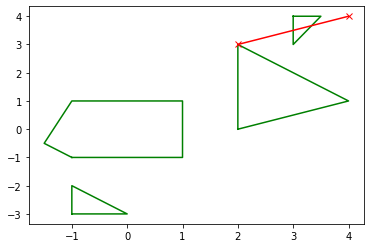

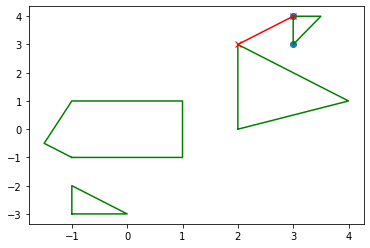

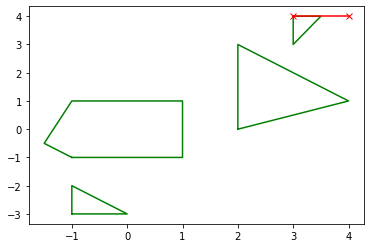

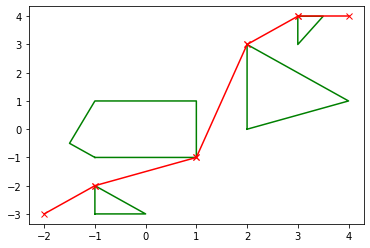

In [248]:
planned_path = find_paths(start, end, polys)
for poly in polys:
  plt.plot(*poly.exterior.xy, 'g')
for path in planned_path:
  plt.plot(*path.xy, 'rx-')
plt.show()